In [1]:
from proximity.network import Network
from itertools import combinations
import pandas as pd
import networkx as nx
import graph_tool.all as gt
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [8]:
#read ppi network
G = nx.from_pandas_edgelist(pd.read_csv('data/Gene_Gene.csv'), 'source', 'target')

In [9]:
_df = pd.read_csv('data/chemical_target_both_version.csv')

In [10]:
net = Network(G)

In [11]:
#version 2
temp = _df.drop('version', axis=1).drop_duplicates().groupby('chemName')['GeneId'].apply(set).to_dict()

### Targtes in ppi

In [12]:
df = _df.drop('version', axis=1).drop_duplicates()

In [13]:
df.groupby('GeneId')['chemName'].size().value_counts()

1    117
2     19
3      8
4      1
Name: chemName, dtype: int64

In [14]:
dict_temp = df.groupby('GeneId')['chemName'].size().to_dict()

In [15]:
dict_temp['ALB'], dict_temp['HSD17B10']

(2, 4)

In [16]:
hallmark = pd.read_csv('data/hallmark_of_aging_cleaned.csv')
dict_color = dict(zip(hallmark.hallmark.unique(), sns.color_palette('tab20', hallmark.hallmark.nunique()).as_hex()))
hallmark['color'] = hallmark.hallmark.apply(lambda x: dict_color[x])
node_color = dict(zip(hallmark.GeneId, hallmark.color))

In [17]:
G = gt.Graph(directed=False)
ids = G.add_edge_list(pd.read_csv('data/Gene_Gene.csv')[['source', 'target']].values, hashed=True)

In [18]:
g = gt.GraphView(G, vfilt=[True if ids[v] in df.GeneId.unique() else False for v in G.iter_vertices()])
#g = gt.GraphView(g, vfilt=gt.label_largest_component(g))
g.num_vertices()

145

In [19]:
pos = gt.arf_layout(g, a=3)

In [20]:
vt = g.new_vp('string')
vc = g.new_vp('float')
vb = g.new_vp('string')
for v in g.iter_vertices(): 
    vt[v] = ids[v]
    vc[v] = dict_temp[ids[v]]
    vb[v] = node_color[ids[v]] if ids[v] in node_color else '#d6d5d5'

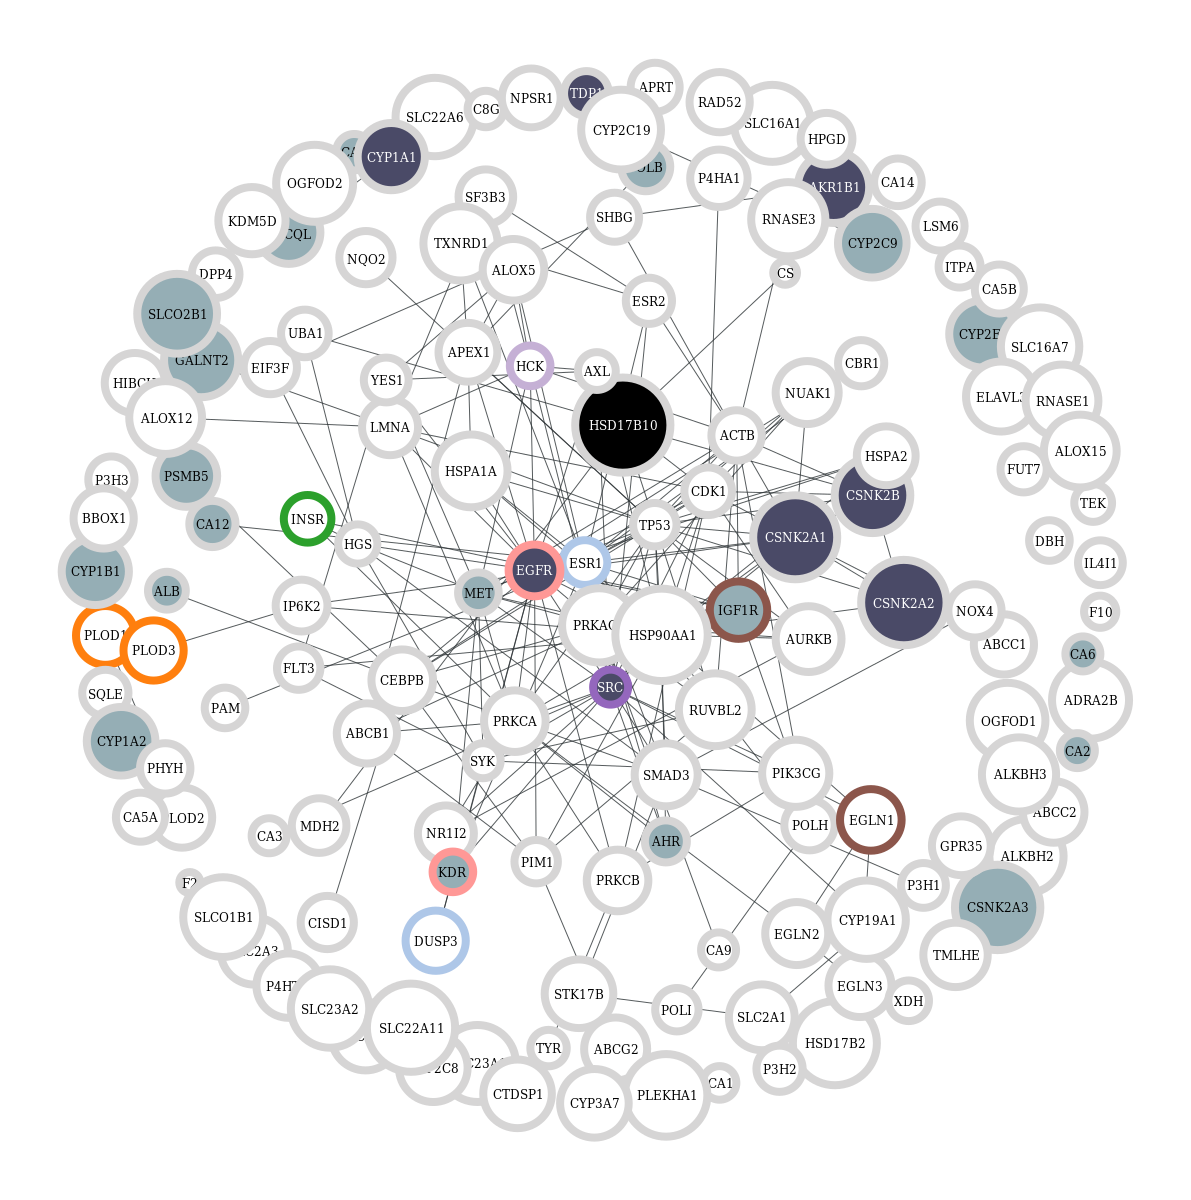

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f71debf3fd0, at 0x7f72161cd210>

In [21]:
gt.graph_draw(g, pos=pos, vertex_text=vt, vertex_pen_width=4, output_size=(600,600), vertex_size=10, vertex_fill_color=vc, vertex_color=vb,
              vcmap=plt.cm.bone_r, edge_pen_width=0.5)#, output='data/out.svg')

In [22]:
{'ER', 'PG', 'NFKB1', 'PPARG', 'TP53', 'AMPK', 'SIRT6', 'NOS1', 'CRP', 'HSP90',
'EFNB1', 'EFNB3', 'PIK3CD', 'BCL2L1', 'MCL1', 'HIF1A', 'CDKN1A', 'SERPINE1', 'SERPINB2',
'IL6', 'IL1B', 'CCL2', 'IL1A', 'TNF', 'VCAM1', 'PMAIP1', 'MAPK8',
'GSK3B', 'MAPK14'} & set(df.GeneId.unique())

{'TP53'}

In [23]:
for v in g.iter_vertices():
    if vb[v] != '#d6d5d5': print(v, vb[v])

209 #c5b0d5
1224 #aec7e8
1827 #9467bd
1834 #8c564b
2667 #2ca02c
3559 #ff9896
5293 #aec7e8
5935 #ff7f0e
7004 #ff7f0e
8087 #ff9896
9983 #8c564b


In [24]:
dict_color

{'Altered intercellular communications': '#1f77b4',
 'Genomic instability': '#aec7e8',
 'Extracellular matrix stiffness': '#ff7f0e',
 'Cellular senescence': '#ffbb78',
 'Deregulated nutrient signaling': '#2ca02c',
 'Epigenetic shift': '#98df8a',
 'Impaired proteostasis': '#d62728',
 'Inflammation': '#ff9896',
 'Mitochondrial dysfunction': '#9467bd',
 'Retrotranspositions': '#c5b0d5',
 'Stem cell exhaustion': '#8c564b',
 'Telomere attrition': '#c49c94'}

### separation

In [35]:
chem_colors = {
    'Ascorbic acid': '#008480',
    'Corilagin': '#eba628',
    'Ellagic acid': '#eba628',
    'Gallic acid': '#7644b5',
    'Kaempferol': '#007f36',
    'Pedunculagin': '#eba628',
    'Pyrogallol': '#77c600',
    'Quercetin': '#007f36',
    'Citric acid': '#0e679f'
}

In [50]:
sep_df = []
for a,b in combinations(temp.keys(), 2): sep_df.append([a, b, net.get_separation(temp[a], temp[b])])
sep_df = pd.DataFrame(sep_df, columns=['A', 'B', 'sep'])
sep_df = sep_df[sep_df.sep.notnull()]
sep_df.head(1)

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,A,B,sep
0,Ascorbic acid,Citric acid,0.035632


In [51]:
sep_df.sep.apply(lambda x: True if x>0 else False).value_counts()

True     13
False     8
Name: sep, dtype: int64

In [52]:
sep_df = sep_df[sep_df.sep >= 0]

In [53]:
sep_df[sep_df.A == 'Ellagic acid']

,A,B,sep
21,Ellagic acid,Gallic acid,0.446336
24,Ellagic acid,Pyrogallol,0.144444


In [54]:
g = gt.Graph(directed=False)
ew = g.new_ep('float')
ec = g.new_ep('string')
#ids = g.add_edge_list(sep_df.drop('sep',axis=1).values, hashed=True, eprops=[ew, ec])
ids = g.add_edge_list(sep_df.values, hashed=True, eprops=[ew, ec])
for e in g.edges(): ew[e] = ew[e] * 30 #* -1

In [55]:
vt = g.new_vp('string')
vc = g.new_vp('string')
for v in g.iter_vertices(): 
    vt[v] = ids[v]
    vc[v] = chem_colors[ids[v]]

In [62]:
pos = gt.sfdp_layout(g)

In [64]:
gt.graph_draw(g, pos=pos, vertex_text=vt, vertex_font_size=10, edge_pen_width=ew, vertex_pen_width=4, 
              vertex_fill_color='#9f9d9d', edge_color='#00854f', vertex_color=vc, output='data/out.svg')  #00854f, 840000

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f71dfd16210, at 0x7f72161d3fd0>